<a href="https://colab.research.google.com/github/manisharavindh/my-first-pytorch-model/blob/main/01_pytorch_workflow_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(torch.__version__)

2.6.0+cu124


In [31]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [32]:
# data with know parameters
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight*X + bias
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [33]:
# train test split
split_size = int(0.8 * len(X))

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

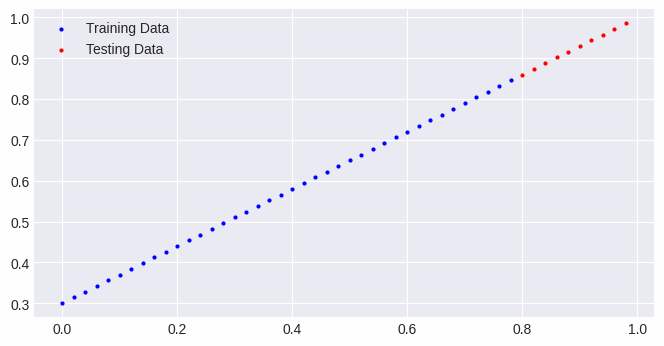

In [34]:
# visualization
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

def pred_plot(train_data = X_train,
             train_labels = y_train,
             test_data = X_test,
             test_labels = y_test,
             predictions = None):

  plt.figure(figsize=(8, 4))

  plt.scatter(train_data.to('cpu'), train_labels.to('cpu'), c='b', s=4, label="Training Data")
  plt.scatter(test_data.to('cpu'), test_labels.to('cpu'), c='r', s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data.to('cpu'), predictions.to('cpu'), c='g', s=4, label="Predictions")

  plt.legend()
pred_plot()

In [35]:
# model building
class LinearRegressingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

model = LinearRegressingModel()
model, model.state_dict()

(LinearRegressingModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.0078]])),
              ('linear_layer.bias', tensor([-0.0134]))]))

In [36]:
# data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# model to GPU
model.to(device)
next(model.parameters()).device

device(type='cpu')

In [37]:
# training
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# loop
epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5894099473953247 | Test Loss: 0.9243953824043274
Epoch: 10 | Train Loss: 0.45040997862815857 | Test Loss: 0.7353953123092651
Epoch: 20 | Train Loss: 0.3114098906517029 | Test Loss: 0.5463953614234924
Epoch: 30 | Train Loss: 0.17240996658802032 | Test Loss: 0.3573954999446869
Epoch: 40 | Train Loss: 0.06796637922525406 | Test Loss: 0.17725908756256104
Epoch: 50 | Train Loss: 0.056551624089479446 | Test Loss: 0.06258179247379303
Epoch: 60 | Train Loss: 0.049590833485126495 | Test Loss: 0.0657571479678154
Epoch: 70 | Train Loss: 0.038452669978141785 | Test Loss: 0.09528481215238571
Epoch: 80 | Train Loss: 0.02980879507958889 | Test Loss: 0.07046198099851608
Epoch: 90 | Train Loss: 0.020033201202750206 | Test Loss: 0.033139366656541824
Epoch: 100 | Train Loss: 0.009728223085403442 | Test Loss: 0.022368406876921654
Epoch: 110 | Train Loss: 0.0007882416248321533 | Test Loss: 0.004094135947525501
Epoch: 120 | Train Loss: 0.0016241356497630477 | Test Loss: 0.0027019202

In [38]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7003]])),
             ('linear_layer.bias', tensor([0.2994]))])

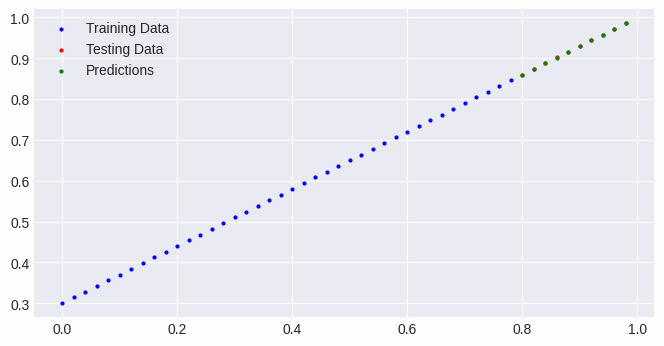

In [39]:
# predictions and evaluations
model.eval()
with torch.inference_mode():
  new_pred = model(X_test)

pred_plot(predictions=new_pred)

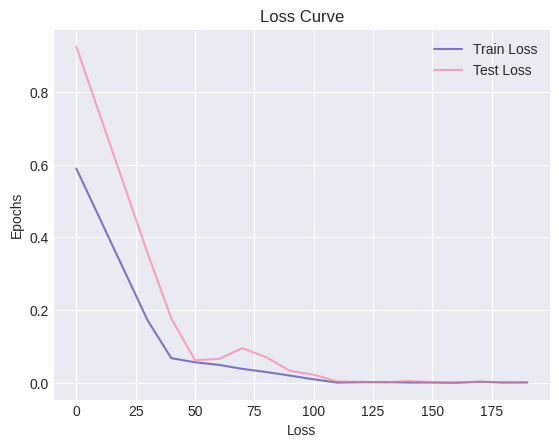

In [40]:
# loss curve
plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), label="Train Loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), label="Test Loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.title("Loss Curve")
plt.legend()

In [41]:
# saving the model
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(
    obj=model.state_dict(),
    f=MODEL_SAVE_PATH
)
print(f"model saved to: {MODEL_SAVE_PATH}")

model saved to: models/01_pytorch_workflow_model.pth


In [42]:
# loading the saved model
loaded_model = LinearRegressingModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [43]:
loaded_model.to(device)

loaded_model.eval()
with torch.inference_mode():
  loaded_model_pred = loaded_model(X_test)

loaded_model_pred == new_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])